In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
pip install "numpy>=1.16.5,<1.23.0"

Note: you may need to restart the kernel to use updated packages.


In [5]:
# grader-required-cell
import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import matplotlib.pyplot as plt
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import img_to_array, load_img

In [6]:
# atur lokasi
dir_dataset = "/kaggle/input/corn-or-maize-leaf-disease-dataset/data" # Mendefinisikan path dataset

dir_Blight = os.path.join("/kaggle/input/corn-or-maize-leaf-disease-dataset/data/Blight")
dir_Common_rust = os.path.join("/kaggle/input/corn-or-maize-leaf-disease-dataset/data/Common_Rust")
dir_Grey_leaf_spot = os.path.join("/kaggle/input/corn-or-maize-leaf-disease-dataset/data/Gray_Leaf_Spot")
dir_Healthy = os.path.join("/kaggle/input/corn-or-maize-leaf-disease-dataset/data/Healthy")

# # cek data per dir
total_Blight = len(os.listdir(dir_Blight))
total_Common_rust = len(os.listdir(dir_Common_rust))
total_Grey_leaf_spot = len(os.listdir(dir_Grey_leaf_spot))
total_Healthy  = len(os.listdir(dir_Healthy))

# cek total data
number_label = {}
total_data = 0
for i in os.listdir(dir_dataset):
    counting = len(os.listdir(os.path.join(dir_dataset, i)))
    number_label[i] = counting
    total_data += counting

print(f'''
Total dari Blight                    : {total_Blight}  data
Total dari Common Rust               : {total_Common_rust}  data
Total dari Grey Leaf Spot            : {total_Grey_leaf_spot}  data
Total dari Healty                    : {total_Healthy}  data
Total Dataset                        : {str(total_data)} data
''')


Total dari Blight                    : 1146  data
Total dari Common Rust               : 1306  data
Total dari Grey Leaf Spot            : 574  data
Total dari Healty                    : 1162  data
Total Dataset                        : 4188 data



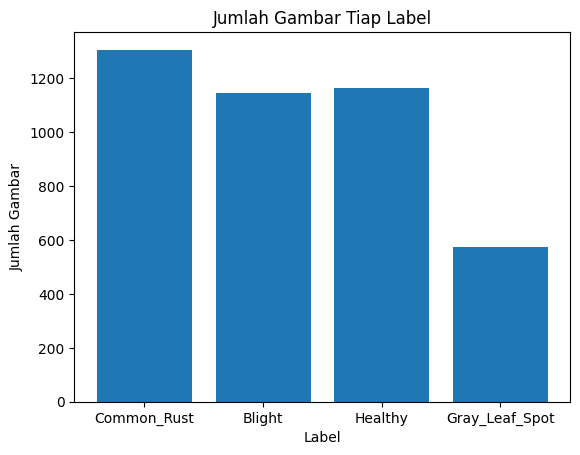

In [7]:
# Visualisasi jumlah gambar tiap kelas
import matplotlib.pyplot as plt

plt.bar(number_label.keys(), number_label.values());
plt.title("Jumlah Gambar Tiap Label");
plt.xlabel('Label');
plt.ylabel('Jumlah Gambar');

In [8]:
#Train dan Validation dataset

val_size = 0.3 #menentukan ukuran validasi 40%

Train_datagen = ImageDataGenerator(
    rotation_range = 40,
    brightness_range = [0.2,1.0],
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = "nearest",
    rescale = 1./255,
    validation_split = val_size
)

Validation_datagen = ImageDataGenerator(
    rotation_range = 40,
    brightness_range = [0.2,1.0],
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = "nearest",
    rescale = 1./255,
    validation_split = val_size
)

In [9]:
# Mengatur lebar dan tinggi gambar
img_width = 224
img_height = 224
channels = 3
batch_size = 16

# Train dan Validation generator  dengan mode categorical
Train_generator = Train_datagen.flow_from_directory(
    dir_dataset,
    target_size = (img_width,img_height),
    color_mode = "rgb",
    class_mode = "categorical",
    batch_size = batch_size,
    shuffle = True,
    subset = "training"
)

Validation_generator = Validation_datagen.flow_from_directory(
    dir_dataset,
    target_size = (img_width,img_height),
    color_mode = "rgb",
    class_mode = "categorical",
    batch_size = batch_size,
    shuffle = False,
    subset = "validation"
)

Found 2934 images belonging to 4 classes.
Found 1254 images belonging to 4 classes.


In [10]:
##### Pembuatan model
from keras import regularizers
# inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_width, img_height,3))

# for layer in inception_model.layers:
#   layer.trainable = False

model = tf.keras.models.Sequential(
    [    #  inception_model,
     tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
     tf.keras.layers.MaxPooling2D(2,2),
     tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
     tf.keras.layers.MaxPooling2D(2,2),
     tf.keras.layers.Conv2D(512, (3,3), activation='relu'),
     tf.keras.layers.MaxPooling2D(2,2),
     tf.keras.layers.Flatten(),
     # Droupout
     tf.keras.layers.Dropout(0.2),
     tf.keras.layers.Dense(512, activation = 'relu', kernel_regularizer=regularizers.l2(0.01)),
     tf.keras.layers.Dense(128, activation='relu'),
     tf.keras.layers.Dense(64, activation='relu'),
     tf.keras.layers.Dense(64, activation='relu'),
     tf.keras.layers.Dense(32, activation='relu'),
     tf.keras.layers.Dense(4, activation='softmax')
    ]
)

In [11]:
# Penggunaan Optimizer 'Adam' dengan learning rate 0.00146
Optimizer = tf.keras.optimizers.Adam(1e-5)
model.compile(optimizer=Optimizer,
                loss='categorical_crossentropy',
                metrics=['accuracy']) 

In [12]:
# create callbacks
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs['accuracy'] >= 0.9 and logs['val_accuracy'] >= 0.8:
            print("\nReached 80% accuracy and testing accuracy so cancelling training!")
            self.model.stop_training = True

In [14]:
callbacks = myCallback()
history = model.fit(Train_generator,
                    validation_data = Validation_generator,
                    epochs = 60,
                    verbose = 1,
                    callbacks=callbacks)

Epoch 1/60
184/184 [==============================] - 69s 377ms/step - loss: 3.0682 - accuracy: 0.7560 - val_loss: 2.2473 - val_accuracy: 0.7576
Epoch 2/60
184/184 [==============================] - 66s 360ms/step - loss: 1.8164 - accuracy: 0.7829 - val_loss: 1.5524 - val_accuracy: 0.7871
Epoch 3/60
184/184 [==============================] - 67s 364ms/step - loss: 1.3607 - accuracy: 0.8027 - val_loss: 1.2966 - val_accuracy: 0.7576
Epoch 4/60
184/184 [==============================] - 66s 357ms/step - loss: 1.1504 - accuracy: 0.8016 - val_loss: 1.1149 - val_accuracy: 0.7847
Epoch 5/60
184/184 [==============================] - 66s 360ms/step - loss: 1.0177 - accuracy: 0.8057 - val_loss: 0.9895 - val_accuracy: 0.8030
Epoch 6/60
184/184 [==============================] - 66s 361ms/step - loss: 0.9030 - accuracy: 0.8108 - val_loss: 0.9024 - val_accuracy: 0.7974
Epoch 7/60
184/184 [==============================] - 66s 361ms/step - loss: 0.8300 - accuracy: 0.8115 - val_loss: 0.8432 - val_ac

In [15]:
Train_generator.class_indices

{'Blight': 0, 'Common_Rust': 1, 'Gray_Leaf_Spot': 2, 'Healthy': 3}

1/1 [==============================] - 0s 22ms/step
Healty
Softmax Probabilities:
[[0. 0. 0. 1.]]


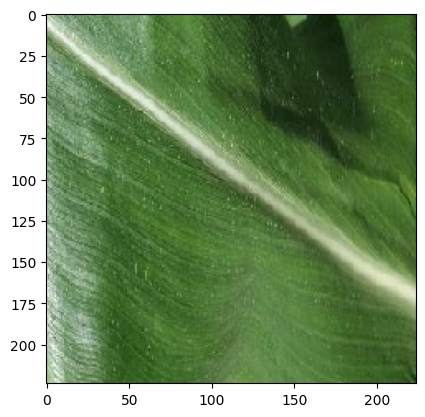

In [19]:
from tensorflow.keras.preprocessing import image

import numpy as np
img_source = "/kaggle/input/corn-or-maize-leaf-disease-dataset/data/Healthy/Corn_Health (1021).jpg"
image_load = image.load_img(img_source, target_size = (img_width,img_height))
imgplot = plt.imshow(image_load)
x = image.img_to_array(image_load)
x = np.expand_dims(x, axis=0)
probs = model.predict(x)

highest = np.argmax(probs)

if highest == 0:
  print("Blight")
elif highest == 1:
  print("Common rust")
elif highest == 2:
  print("Gray Leaf Spot")
else:
  print("Healty")
  

# print softmax probabilities
print('Softmax Probabilities:')
print(probs)